In [2]:
import torch
import torch.nn as nn
import numpy as np
import gradio as gr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecompBlock(nn.Module):
    def __init__(self, kernel_size=25):
        super().__init__()
        self.pad = kernel_size // 2
        self.avg = nn.AvgPool1d(kernel_size, stride=1, padding=self.pad, count_include_pad=False)
    def forward(self, x):
        trend = self.avg(x.transpose(1,2)).transpose(1,2)
        seasonal = x - trend
        return seasonal, trend

class DecompTransformer(nn.Module):
    def __init__(self, feature_dim=9, d_model=64, nhead=4, num_layers=2, pred_len=14):
        super().__init__()
        self.decomp = DecompBlock(kernel_size=25)
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, pred_len)
    def forward(self, x):
        seasonal, trend = self.decomp(x)
        x = self.input_proj(seasonal + trend)
        x = self.pos(x)
        x = self.transformer(x)
        x = self.fc_out(x.mean(dim=1))
        return x.unsqueeze(-1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DecompTransformer(feature_dim=9, pred_len=14).to(device)
model.load_state_dict(torch.load("/kaggle/input/best_model/pytorch/default/1/best_model.pth", map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


DecompTransformer(
  (decomp): DecompBlock(
    (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(12,))
  )
  (input_proj): Linear(in_features=9, out_features=64, bias=True)
  (pos): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=14, bias=True)
)

In [5]:
import pandas as pd
data = pd.read_csv("/kaggle/input/air-quality-data-in-india/city_day.csv") 

city = "Delhi"
data = data[data['City'] == city].copy()

cols = ['Date', 'PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2']
data = data[cols].dropna().reset_index(drop=True)

data['AQI'] = (
    0.45 * data['PM2.5'] +
    0.25 * data['PM10'] +
    0.10 * data['NO2'] +
    0.10 * data['SO2'] +
    0.10 * data['CO']
)
data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,AQI
0,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,299.0280
1,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,156.0745
2,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,76.5630
3,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,134.0960
4,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,125.4975


In [6]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

day_of_year = data['Date'].dt.dayofyear
seasonal = 15 * np.sin(2 * np.pi * day_of_year / 365)
pollution_effect = 0.12 * data['AQI'] + 0.04 * data['NO2'] + 0.03 * data['SO2']
np.random.seed(42)
noise = np.random.normal(0, 5, len(data))

data['Hospital_Admissions'] = (40 + seasonal + pollution_effect + noise).astype(int)

data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,AQI,Hospital_Admissions
0,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,299.0280,80
1,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,156.0745,60
2,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,76.5630,54
3,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,134.0960,66
4,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,125.4975,56


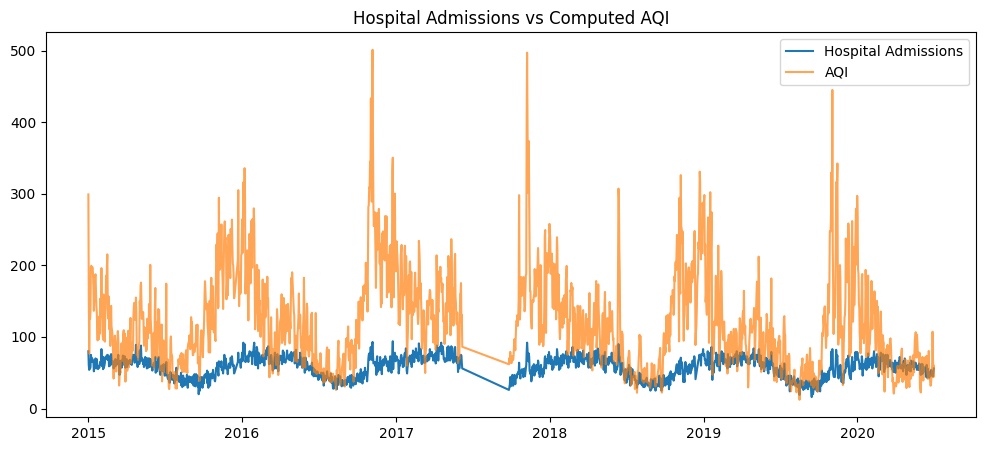

In [7]:
plt.figure(figsize=(12,5))
plt.plot(data['Date'], data['Hospital_Admissions'], label='Hospital Admissions')
plt.plot(data['Date'], data['AQI'], label='AQI', alpha=0.7)
plt.legend(); plt.title('Hospital Admissions vs Computed AQI');
plt.show()

In [8]:
features = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','AQI']
target = ['Hospital_Admissions']

from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(data[features])
scaler_y = StandardScaler().fit(data[target])

# GRADIO INTERFACE------

In [9]:
def forecast_admissions(PM25, PM10, NO, NO2, NOx, NH3, CO, SO2, AQI):
    
    x = np.array([[PM25, PM10, NO, NO2, NOx, NH3, CO, SO2, AQI]])
    x_scaled = scaler_x.transform(x)

  
    seq = np.tile(x_scaled, (90, 1))
    seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(seq).cpu().numpy().flatten()

   
    pred_real = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()

    
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, 15), pred_real, marker='o', label='Predicted Admissions')
    plt.xlabel('Days Ahead')
    plt.ylabel('Hospital Admissions')
    plt.title('14-Day Forecast')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

   
    return {f"Day {i+1}": round(float(p), 2) for i, p in enumerate(pred_real)}, plt

In [10]:
inputs = [
    gr.Number(label="PM2.5"),
    gr.Number(label="PM10"),
    gr.Number(label="NO"),
    gr.Number(label="NO2"),
    gr.Number(label="NOx"),
    gr.Number(label="NH3"),
    gr.Number(label="CO"),
    gr.Number(label="SO2"),
    gr.Number(label="AQI"),
]

gr.Interface(
    fn=forecast_admissions,
    inputs=inputs,
    outputs=[
        gr.Label(label="Predicted Admissions (Next 14 Days)"),
        gr.Plot(label="Forecast Plot")
    ],
    title="Hospital Admission Forecasting (FEDformer)",
    description="Predicts next 14-day hospital admissions based on pollutant levels and AQI.",
    examples=[[50, 80, 12, 20, 30, 8, 1, 10, 150]],
    theme="gradio/soft",
).launch(share=True)

theme_schema%400.0.3.json: 0.00B [00:00, ?B/s]

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c13f2d9dd51b6e5b13.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
